目标检测之SSD
===

# 1.什么是SSD
SSD,Single Shot MultiBox Detector。Single Shot说明SSD算法是One-Stage算法，MultiBox指明了SSD是多框预测。SSD的速度与准确度都强于YOLO v1.相比Yolo，SSD采用CNN来直接进行检测，而不是像Yolo那样在全连接层之后做检测。其实采用卷积直接做检测只是SSD相比Yolo的其中一个不同点，另外还有两个重要的改变，一是SSD提取了不同尺度的特征图来做检测，大尺度特征图（较靠前的特征图）可以用来检测小物体，而小尺度特征图（较靠后的特征图）用来检测大物体；二是SSD采用了不同尺度和长宽比的先验框（Prior boxes, Default boxes，在Faster R-CNN中叫做锚，Anchors）。Yolo算法缺点是难以检测小目标，而且定位不准，但是这几点重要改进使得SSD在一定程度上克服这些缺点。

# 2.算法概述
总体思路就是，保存六个层次的特征图:$38 \times 38$，$19 \times 19$，$10 \times 10$，$5 \times 5$，$3 \times 3$，$1 \times 1$，然后经过一定的计算将这些特征图分成两支，一支负责预测location(shape=BS,8732,4)，一支负责预测conf(shape=BS,8732,21)。这两支再加上通过公式计算出来的先验框Priors(shape=8732,4)一起组成pred和target进行MultiLoss计算。Loss的计算同样也是分开Loc和Conf两部分，首先找到每个Ground truth box对应的的先验框，然后根据这个位置找到预测值中对应的预测值，同样也找到真实值中的对应位置的真实值，两者做Loss。

## 2.1.采用多尺度特征图用于检测
其实就是采用金字塔网络。所谓多尺度采用大小不同的特征图，CNN网络一般前面的特征图比较大，后面会逐渐采用stride=2的卷积或者pool来降低特征图大小。一个比较大的特征图和一个比较小的特征图，它们都用来做检测。这样做的好处是比较大的特征图来用来检测相对较小的目标，而小的特征图负责检测大目标，如图4所示，8x8的特征图可以划分更多的单元，但是其每个单元的先验框尺度比较小。具体来说，就是检测$38 \times 38$，$19 \times 19$，$10 \times 10$，$5 \times 5$，$3 \times 3$，$1 \times 1$这六种大小的特征图。

## 2.2.采用卷积进行检测
与Yolo最后采用全连接层不同，SSD直接采用卷积对不同的特征图来进行提取检测结果。对于形状为$m\times n \times p$的特征图，只需要采用$3\times 3 \times p$这样比较小的卷积核得到检测值。

## 2.3.设置先验框
在Yolo中，每个单元预测多个边界框，但是其都是相对这个单元本身（正方块），但是真实目标的形状是多变的，Yolo需要在训练过程中自适应目标的形状。而SSD借鉴了Faster R-CNN中anchor的理念，每个单元设置尺度或者长宽比不同的先验框，预测的边界框（bounding boxes）是以这些先验框为基准的，在一定程度上减少训练难度。一般情况下，每个单元会设置多个先验框，其尺度和长宽比存在差异，目标分别采用最适合它们形状的先验框来进行训练

### 2.3.1.先验框的匹配规则
确定训练图片中的ground truth与哪个先验框来进行匹配，与之匹配的先验框所对应的边界框将负责预测它。在Yolo中，ground truth的中心落在哪个单元格，该单元格中与其IOU最大的边界框负责预测它。但是在SSD中却完全不一样，SSD的先验框与ground truth的匹配原则主要有两点
1. 对于图片中每个ground truth，找到与其IOU最大的先验框，该先验框与其匹配，这样，可以保证每个ground truth一定与某个先验框匹配。通常称与ground truth匹配的先验框为正样本。若一个先验框没有与任何ground truth进行匹配，那么该先验框只能与背景匹配，就是负样本。
2. 对于剩余的未匹配先验框，若某个ground truth的IOU大于某个阈值(一般是0.5)，那么该先验框也与这个ground truth进行匹配。

第一个原则保证每个ground truth都有一个先验框与之相对应，也就是说都会存在正样本，但是这个原则会导致正样本极少，负样本极多，这样正负样本极不平衡。所以有了第二个原则。但是第二个会导致的一个结果就是一个ground truth有可能对应多个先验框，这是可以的。如果多个ground truth与某个先验框 \text{IOU} 大于阈值，那么先验框只与IOU最大的那个先验框进行匹配。第二个原则一定在第一个原则之后进行。下图是一个匹配示意图，其中绿色的GT是ground truth，红色为先验框，FP表示负样本，TP表示正样本<br/>
![images](Images/03/02/02_02_001.png)

### 2.3.2.负样本的处理
尽管一个ground truth可以与多个先验框匹配，但是ground truth相对先验框还是太少了，所以负样本相对正样本会很多。为了保证正负样本尽量平衡，SSD采用了hard negative mining，就是对负样本进行抽样，抽样时按照置信度误差（预测背景的置信度越小，误差越大）进行降序排列，选取误差的较大的top-k作为训练的负样本，以保证正负样本比例接近1:3。而对于正负样本数量不均衡的数据集(这里假设负样本数量圆圆大于正样本数量)，通常的做法有四种，可以参考[](../01.Basic/数据不均衡.ipynb)

具体来说，在$38 \times 38$的特征图上通过$3 \times 3$卷积层预测4个不同宽高比的box，$19 \times 19$特征图上预测6个，$10 \times 10$特征图预测6个，$5 \times 5$特征图预测6个，$3 \times 3$特征图预测4个，$1 \times 1$特征图预测4个，所以就有$38 \times 38 \times 4+19 \times 19 \times 6+10 \times 10 \times 6+5 \times 5 \times 6+3 \times 3 \times 4+4 = 8732$，这个8732是最终预测框的个数,同时也是先验框的个数

## 2.4.anchor box的维度
SSD300网络的输出是一个包含3个值的tuple
1. Loc的信息，维度为?,8732,4
2. conf置信度信息，维度为?,8732,21
3. 概率信息，维度为8732,4

8372是怎么来的？我们知道SSD是多尺度特征检测，其中在$38 \times 38$的特征图上通过$3 \times 3$卷积层预测4个不同宽高比的box，$19 \times 19$特征图上预测6个，$10 \times 10$特征图预测6个，$5 \times 5$特征图预测6个，$3 \times 3$特征图预测4个，$1 \times 1$特征图预测4个，所以就有$38 \times 38 \times 4+19 \times 19 \times 6+10 \times 10 \times 6+5 \times 5 \times 6+3 \times 3 \times 4+4 = 8732$，这个8732是最终预测框的个数

## 2.5.anchor box的计算方法
SSD300的输入图片是$300 \times 300$的,无论特征图的尺寸多大，每个单元格的中心点的计算公式都是一样的，假设单元格的宽度为$\omega_d$，单元格的横纵坐标为$(i,j)$.$(i,j)$一定是从零开始，并且等于特征图尺寸-1.那么当前单元格的中心点坐标就是$[\frac{j+0.5}{\omega_d}, \frac{i+0.5}{\omega_d}]$

### 2.5.1.38*38的特征图
单元格宽度为$\omega_d=\frac{300}{8}=37.5$。每个单元格上有4个default box，分为小正方形B1，大正方形B2，长方形B3，以及长方形B4，四个default box的中心点坐标可以通过上面的公式计算出来，那么四个default box的宽度和长度如下
$$\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{30}{300}, \frac{30}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{60}{300}}, \sqrt{\omega_{min}^h \times \frac{60}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3)
\end{eqnarray}$$

### 2.5.2.19*19的特征图
单元格宽度为$\omega_d=\frac{300}{16}=18.75$。每个单元格上有6个default box，分为小正方形B1，大正方形B2，长方形B3、B4、B5，B6，6个default box的宽度和长度如下
$$\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{60}{300}, \frac{60}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{111}{300}}, \sqrt{\omega_{min}^h \times \frac{111}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3) \\
B5&=&(w_5,h_5)=(\omega_{min}^w \times \sqrt{3}, \frac{\omega_{min}^h}{\sqrt{3}}) \\
B4&=&(w_6,h_6)=(h_5,w_5)
\end{eqnarray}$$

### 2.5.3.10*10的特征图
单元格宽度为$\omega_d=\frac{300}{32}=9.375$。每个单元格上有6个default box，分为小正方形B1，大正方形B2，长方形B3、B4、B5，B6，6个default box的宽度和长度如下
$$\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{111}{300}, \frac{111}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{162}{300}}, \sqrt{\omega_{min}^h \times \frac{162}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3) \\
B5&=&(w_5,h_5)=(\omega_{min}^w \times \sqrt{3}, \frac{\omega_{min}^h}{\sqrt{3}}) \\
B4&=&(w_6,h_6)=(h_5,w_5)
\end{eqnarray}$$

### 2.5.4.5*5的特征图
单元格宽度为$\omega_d=\frac{300}{64}=4.6875$。每个单元格上有6个default box，分为小正方形B1，大正方形B2，长方形B3、B4、B5，B6，6个default box的宽度和长度如下
$$\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{162}{300}, \frac{162}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{213}{300}}, \sqrt{\omega_{min}^h \times \frac{213}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3) \\
B5&=&(w_5,h_5)=(\omega_{min}^w \times \sqrt{3}, \frac{\omega_{min}^h}{\sqrt{3}}) \\
B4&=&(w_6,h_6)=(h_5,w_5)
\end{eqnarray}$$

### 2.5.5.3*3的特征图
单元格宽度为$\omega_d=\frac{300}{100}=3$。每个单元格上有4个default box，分为小正方形B1，大正方形B2，长方形B3、B4,4个default box的宽度和长度如下
$$\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{213}{300}, \frac{213}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{264}{300}}, \sqrt{\omega_{min}^h \times \frac{264}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3)
\end{eqnarray}$$

### 2.5.6.1*1的特征图
单元格宽度为$\omega_d=\frac{300}{300}=1$。每个单元格上有4个default box，分为小正方形B1，大正方形B2，长方形B3、B4,4个default box的宽度和长度如下
$$\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{264}{300}, \frac{264}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{315}{300}}, \sqrt{\omega_{min}^h \times \frac{315}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3)
\end{eqnarray}$$

# 3.网络结构
SSD的基础架构是VGG16(也有人将它的基础架构变为Resnet50,Darknet19或者Darknet53).SSD根据输入图片的大小分为SSD300和SSD512两种结构，我们主要介绍SSD300结构。在神经网络进行计算的过程中，我们会把过程中生成的6种特征图的结果保存下来。然后利用网络中的vgg以及extras对其进行前向传播，可以得到用于loc预测的结果，和用于conf预测的结果

# 4.数据集
数据集的操作很简单，主要就是进行了一些图像增强的功能，然后返回归一化的image以及targets

# 5.损失函数
损失函数定义为位置误差(locatization loss， loc)与置信度误差(confidence loss, conf)的加权和
$$L(x,c,\ell,g)=\frac{1}{N}[L_{conf}(x,c)+\alpha L_{loc}(x,\ell,g)]$$
其中N是先验框的正样本数量。这里$x_{ij}^p \in \{1,0\}$为一个指示参数，当$x_{ij}^p=1$时表示第i个先验框与第j个ground truth匹配，并且ground truth的类别为p。c为类别置信度预测值，$\ell$为先验框所对应的边界框的位置预测值，而g是ground truth的位置参数。<br/>
预测值包括三个部分:loc_data(BS,8732,4),conf_data(BS,8732,21),priors(8732,4)，真实值包括label和ground truth box

In [ ]:
import torch
loc_t = torch.Tensor(num, num_priors, 4)
conf_t = torch.LongTensor(num, num_priors)
for idx in range(num):
    truths = targets[idx][:, :-1].data
    labels = targets[idx][:, -1].data
    defaults = priors.data
    lpsu.match(self.threshold, truths, defaults, self.variance, labels, loc_t, conf_t, idx)

1. loc_t的shape就是$BS,8732,4$，conf_t的shape就是$BS,8732,21$。然后开始操作每一张图片
2. truths就是当前图片上的所有ground truth box，labels就是当前图片上的所有labels
3. 开始找到与每个ground truth box相对应的先验框的index等信息。threshold就是阈值~0.5，self.variance=[0.1,0.2],对应于每个锚框的方差。真正核心的就是这一步

## 5.1.loc_t与conf_t的填充

In [ ]:
overlaps = jaccard(truths,point_form(priors))
best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
best_truth_idx.squeeze_(0)
best_truth_overlap.squeeze_(0)
best_prior_idx.squeeze_(1)
best_prior_overlap.squeeze_(1)

以下我们假设这张图片上有5个ground truth box
1. 首先将priors原先的坐标$x,y,w,h$转化为$x,y,xmax,ymax$的形式
2. 计算IOU重叠率。具体的jaccard就是首先找到每个truth和每个prior box的公共面积，然后计算出每个truth和每个prior box的总体面积，那IOU重叠率就是$IOU=\frac{A_{t \cap p}}{A_{t \cup p} - A_{t \cap p}}$，其中$A_{t \cap p}$就是真实框t和先验框p的重叠面积,$A_{t \cup p}$就是真实框t和先验框p的总体面积，计算出来的结果overlaps的shape是$num,8732$，这里的$num$表示这张图片上的ground truth box的数量，如果有5个ground truth box，那么num就是5，每一个元素里面又是一个8732维的向量，每个元素代表的含义就是这个位置的prior box与当前ground truth box的IOU重叠率
3. best_prior_overlap和best_prior_idx的含义。首先best_prior_overlap的shape是$5,1$，每一个元素的含义就是跟当前的ground truth box的IOU重叠率最高的prior的IOU重叠率。best_prior_idx的shape也是$5,1$，每一个元素的含义就是跟当前的ground truth box的IOU重叠率最高的prior的index位置。这个其实就是相当于找到overlaps的每一行的最大值及其最大值所在的位置。
4. 那么接下来best_truth_overlap和best_truth_idx呢，我们可以看出来这是找到overlaps的每一列的最大值以及最大值所在的位置。具体什么含义呢。具体的含义就是找到哪一个ground truth box跟当前的这个prior有着最高的IOU重叠率，以及IOU重叠率到底是多少。所以它俩的shape都是$1,8732$
5. 接下来对这四个变量进行压缩，将他们的1维那个维度去掉，于是就变成了best_truth_idx.shape=8732,best_truth_overlap.shape=8732,best_prior_idx.shape=5,best_prior_overlap.shape=5

In [ ]:
best_truth_overlap.index_fill_(0, best_prior_idx, 2)
for j in range(best_prior_idx.size(0)):
    best_truth_idx[best_prior_idx[j]] = j
matches = truths[best_truth_idx]
conf = labels[best_truth_idx] + 1
conf[best_truth_overlap < threshold] = 0
loc = encode(matches, priors, variances)
loc_t[idx] = loc
conf_t[idx] = conf 

6. 接下来的这一句是将best_truth_overlap上的某些位置的元素设置为2.我们知道best_truth_overlap里面的元素都是在0~1之间的。某些位置具体是哪些位置呢，就是best_prior_idx的元素所指引的那些个位置。这是什么意思呢。首先我们知道best_truth_overlap里面的每个元素的含义就是当前prior跟每一个ground truth box的IOU覆盖率的最大值。best_prior_idx的含义是每个ground truth box跟每一个prior的IOU覆盖率最大值的那个prior的index位置。做一个index_fill_操作之后的结果，就是将那些个需要负责预测的prior的位置上的值赋值为2了，比别的不需要负责预测的prior的位置上的值大了。
7. 然后将truths真值扩充到8732维，每一维上的5个坐标，就是当前位置的prior所负责预测的ground truth box的坐标。
8. 然后将conf上小于阈值的位置设置为0~背景。大于阈值的就是真正需要负责预测的label的值。
9. 然后将方差应用到priors上进行编码。

$$\begin{eqnarray}
\hat{g_x}&=\frac{\frac{T_x+T_w}{2}-P_x}{V[0] \times P_w} \\
\hat{g_y}&=\frac{\frac{T_y+T_h}{2}-P_y}{V[0] \times P_h} \\
\hat{g_w}&=\frac{log(\frac{T_w-T_x}{2}-P_w)}{V[1]} \\
\hat{g_h}&=\frac{log(\frac{T_h-T_y}{2}-P_h)}{V[1]}
\end{eqnarray}$$

In [ ]:
pos = conf_t > 0
pos_idx = pos.unsqueeze(pos.dim()).expand_as(loc_data)

找到每一幅图片的每个ground truth box对应的prior的位置以及loc之后，我们就要计算损失了。我们可以很方便的找到需要负责预测的prior的坐标~pos

## 5.1.位置误差$L_{loc}$
采用Smooth L1 Loss，定义如下：
$$L_{loc}(x,\ell,g)=\sum_{i \in Pos}^N \sum_{m \in \{cx,cy,w,h\}}x_{ij}^kS_{L1}(\ell_i^m-\hat{g}_j^m)$$
$\ell$为预测框，$g$为ground truth box。$(cx,cy)$为补偿后的默认框d的中心
$L_{conf}$为预测框$\ell$和ground truth box $g$的Smooth L1 Loss，$\alpha$的值通过交叉验证设置为1

In [ ]:
loc_p = loc_data[pos_idx].view(-1, 4)
# loc_t [461,4]
loc_t = loc_t[pos_idx].view(-1, 4)
# 计算算定位损失   loc_p 通过网络输出的预测框   loc_t 通过与真值框匹配的锚
loss_l = torch.nn.functional.smooth_l1_loss(loc_p, loc_t, size_average=False)

## 5.2.1.encode的解释

In [ ]:
def encode(matched, priors, variances):
    '''
    将 来自锚框层的方差编码到与这些锚框相匹配到的真值框中
    :param matched:
    :param priors:
    :param variances:
    :return:
    '''
    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

真实预测值其实只是边界框相对于先验框的转换值。先验框位置用$d=(d^{cx},d^{cy},d^w,d^h)$表示

其对应边界框用$b=(b^{cx},b^{cy},b^w,b^h)$表示，那么边界框的预测值$l$其实是$b$相对于$d$的转换值

$$
\begin{split}
l^{cx}&=\frac{b^{cx}-d^{cx}}{d^w} \\
l^{cy}&=\frac{b^{cy}-d^{cy}}{d^h} \\
l^w&=log(\frac{b^w}{d^w}) \\
l^h&=log(\frac{b^h}{d^h})
\end{split}
$$
预测时，你需要反向这个过程，即进行解码(decode)，从预测值$l$中得到边界框的真实位置$b$
$$
\begin{split}
b^{cx}&=d^wl^{cx} + d^{cx} \\
b^{cy}&=d^yl^{cy} + d^{cy} \\
b^w&=d^we^{l^w} \\
b^h&=d^he^{l^h}
\end{split}
$$

具体实现中还有trick，那就是设置variance超参数来调整检测值，通过bool参数variance_encoded_in_target来控制两种模式

当其为True时，表示variance被包含在预测值中，就是上面那种情况。但是如果是False，就需要手动设置超参数variance，用来对$l$的4个值进行放缩，此时边界框需要这样解码
$$
\begin{split}
b^{cx}&=d^w(variance[0] * l^{cx}) + d^{cx} \\
b^{cy}&=d^y(variance[1] * l^{cy}) + d^{cy} \\
b^w&=d^we^{variance[2] * l^w} \\
b^h&=d^he^{variance[3] * l^h}
\end{split}
$$

找到预测值中对应的prior的预测坐标，同样找到真实值中相应位置的坐标，两者做smooth L1损失。

## 5.2.置信度误差$L_{conf}$
采用Softmax Loss
$$
L_{conf}(x,c)=-\sum_{i \in Pos}^Nx_{ij}^plog(\hat{c}_j^p)-\sum_{i \in N_{eg}}log(\hat{c}_i^0)
$$
其中
$$\hat{c}_j^p=\frac{e^{c_i^p}}{\sum_pe^{c_i^p}}$$
这里的置信度误差，就是分类损失，由于正样本很少，负样本太多，对于负样本采用了硬性负开采来进行过滤(按照置信度误差进行排序，取出当前批次正样本的3倍的负样本)。

# 6.网络结构

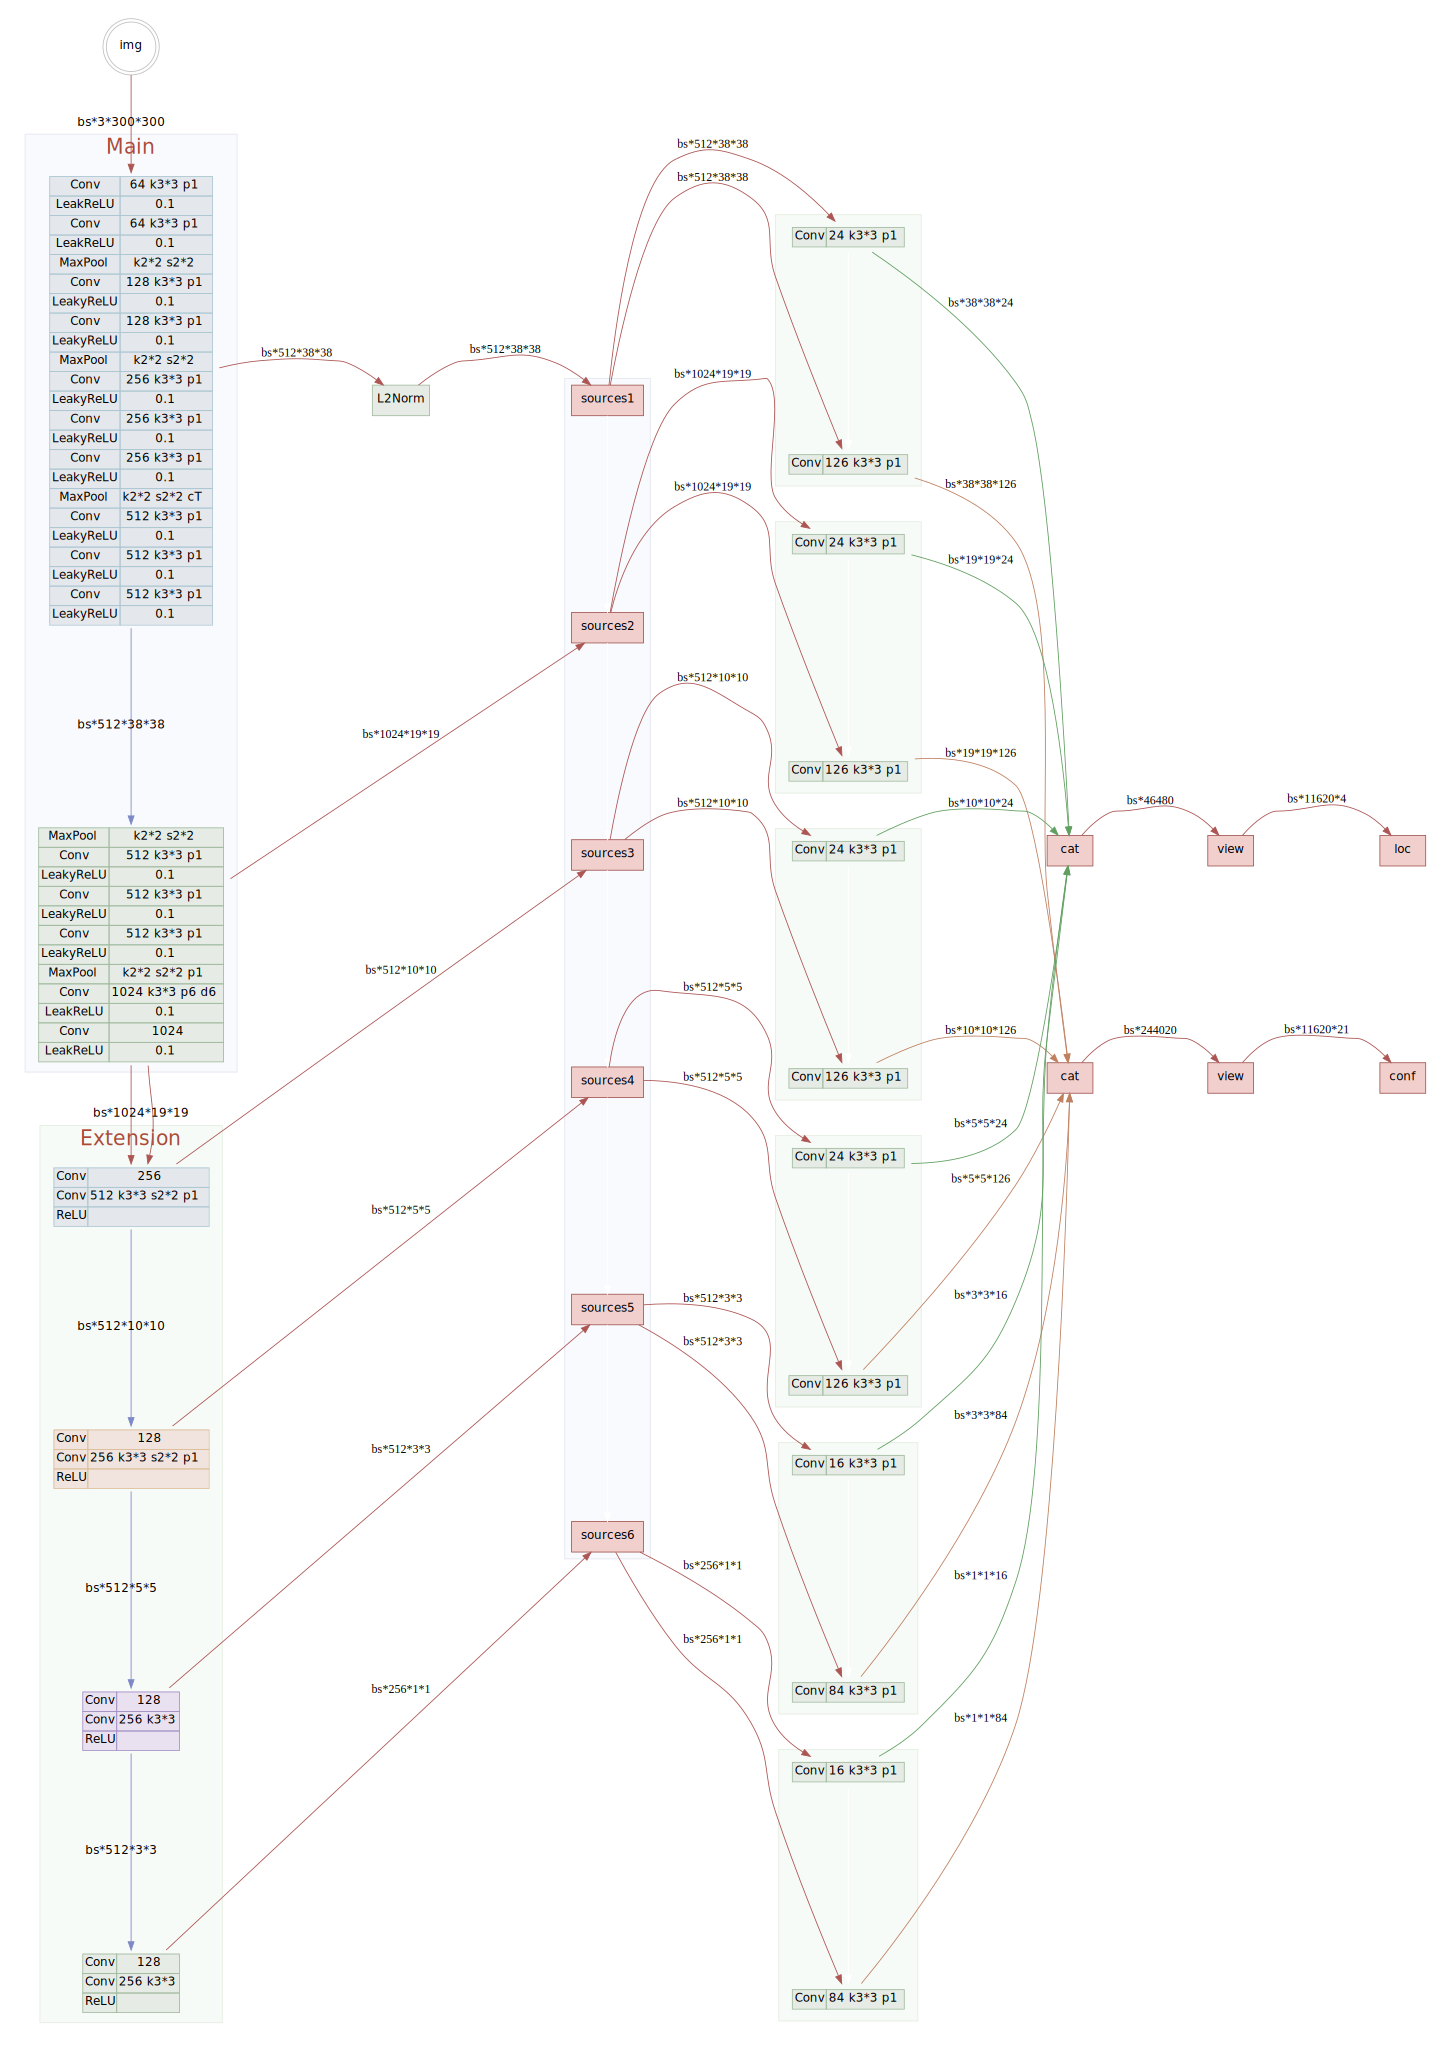

In [1]:
import graphviz

FONT_NAME = "Fira Code Retina"
graph = graphviz.Digraph(name="SSD", format='png', node_attr={'shape': 'plaintext'}, edge_attr = {"constraint":"false"})
graph.attr(rankdir="LR", ranksep="0.5", nodesep="0.8", pad="0.3")

with graph.subgraph(name="cluster1") as sub1:
    sub1.attr(color="#E3E5EF", bgcolor="#F9FAFE")
    with graph.subgraph() as s:
        s.node('block1', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>Conv</td><td>64 k3*3 p1</td></tr>
                    <tr><td>LeakReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>64 k3*3 p1</td></tr>
                    <tr><td>LeakReLU</td><td>0.1</td></tr>
                    <tr><td>MaxPool</td><td>k2*2 s2*2</td></tr>
                    <tr><td>Conv</td><td>128 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>128 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>MaxPool</td><td>k2*2 s2*2</td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>MaxPool</td><td>k2*2 s2*2 cT</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block5', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>MaxPool</td><td>k2*2 s2*2</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>MaxPool</td><td>k2*2 s2*2 p1</td></tr>
                    <tr><td>Conv</td><td>1024 k3*3 p6 d6</td></tr>
                    <tr><td>LeakReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>1024</td></tr>
                    <tr><td>LeakReLU</td><td>0.1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
    sub1.edge("block1", "block5", color="#7D88C7", label="bs*512*38*38", fontname=FONT_NAME)
    sub1.attr(label="Main", fontsize="24", fontcolor="#AA4936", fontname=FONT_NAME, nodesep="0.1")

graph.node('img', shape="doublecircle", color="grey", fontname=FONT_NAME)
graph.edge("img", "block1", label="bs*3*300*300", color="#AC5553", fontname=FONT_NAME)

with graph.subgraph(name="cluster2") as sub2:
    sub2.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block8', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 s2*2 p1</td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block9', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>Conv</td><td>256 k3*3 s2*2 p1</td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block10', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>Conv</td><td>256 k3*3</td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block11', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>Conv</td><td>256 k3*3</td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
    sub2.edge("block8", "block9", color="#7D88C7", label="bs*512*10*10", linewidth='10', fontname=FONT_NAME)
    sub2.edge("block9", "block10", color="#7D88C7", label="bs*512*5*5", fontname=FONT_NAME)
    sub2.edge("block10", "block11", color="#7D88C7", label="bs*512*3*3", fontname=FONT_NAME)
    sub2.attr(label="Extension", fontsize="24", fontcolor="#AA4936", fontname=FONT_NAME)

graph.edge("block5", "block8", color="#AC5553", label="bs*1024*19*19", fontname=FONT_NAME)

graph.node("L2Norm", shape="box", label="L2Norm", color="#A2BBA0", style="filled", fillcolor="#E6ECE5", fontname=FONT_NAME)
graph.node("T1", style="invis")
graph.edge("block1", "T1", constraint="true", style="invis")
graph.edge("T1", "L2Norm", constraint="true", style="invis")
graph.edge("block1", "L2Norm", color ="#AC5553", label="bs*512*38*38")

with graph.subgraph(name="cluster3") as sub3:
    sub3.attr(color="#E3E5EF", bgcolor="#F9FAFE")
    with graph.subgraph() as s:
        s.node("sources1", shape="box", label="sources1", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources2", shape="box", label="sources2", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources3", shape="box", label="sources3", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources4", shape="box", label="sources4", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources5", shape="box", label="sources5", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources6", shape="box", label="sources6", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
    sub3.edge("sources1", "sources2", color ="white")
    sub3.edge("sources2", "sources3", color ="white")
    sub3.edge("sources3", "sources4", color ="white")
    sub3.edge("sources4", "sources5", color ="white")
    sub3.edge("sources5", "sources6", color ="white")
graph.node("T2", style="invis")
graph.edge("L2Norm", "T2", constraint="true", style="invis")
graph.edge("T2", "sources1", constraint="true", style="invis")

graph.edge("L2Norm", "sources1", color ="#AC5553", label="bs*512*38*38")
graph.edge("block5", "sources2", color ="#AC5553", label="bs*1024*19*19")
graph.edge("block8", "sources3", color ="#AC5553", label="bs*512*10*10")
graph.edge("block9", "sources4", color ="#AC5553", label="bs*512*5*5")
graph.edge("block10", "sources5", color ="#AC5553", label="bs*512*3*3")
graph.edge("block11", "sources6", color ="#AC5553", label="bs*256*1*1")

with graph.subgraph(name="cluster4") as sub4:
    sub4.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block12', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>24 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block13', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>126 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub4.edge("block12", "block13", color="#FFFFFF")
graph.node("T3", style="invis")
graph.edge("sources1", "T3", constraint="true", style="invis")
graph.edge("T3", "block12", constraint="true", style="invis")
graph.edge("sources1", "block12", color ="#AC5553", label="bs*512*38*38")
graph.edge("sources1", "block13", color ="#AC5553", label="bs*512*38*38")

with graph.subgraph(name="cluster5") as sub5:
    sub5.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block14', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>24 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block15', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>126 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub5.edge("block14", "block15", color="#FFFFFF")
graph.node("T4", style="invis")
graph.edge("sources2", "T4", constraint="true", style="invis")
graph.edge("T4", "block14", constraint="true", style="invis")
graph.edge("sources2", "block14", color ="#AC5553", label="bs*1024*19*19")
graph.edge("sources2", "block15", color ="#AC5553", label="bs*1024*19*19")

with graph.subgraph(name="cluster6") as sub6:
    sub6.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block16', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>24 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block17', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>126 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub6.edge("block16", "block17", color="#FFFFFF")
graph.node("T5", style="invis")
graph.edge("sources3", "T5", constraint="true", style="invis")
graph.edge("T5", "block16", constraint="true", style="invis")
graph.edge("sources3", "block16", color ="#AC5553", label="bs*512*10*10")
graph.edge("sources3", "block17", color ="#AC5553", label="bs*512*10*10")

with graph.subgraph(name="cluster7") as sub7:
    sub7.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block18', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>24 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block19', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>126 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub7.edge("block18", "block19", color="#FFFFFF")
graph.node("T6", style="invis")
graph.edge("sources4", "T6", constraint="true", style="invis")
graph.edge("T6", "block18", constraint="true", style="invis")
graph.edge("sources4", "block18", color ="#AC5553", label="bs*512*5*5")
graph.edge("sources4", "block19", color ="#AC5553", label="bs*512*5*5")

with graph.subgraph(name="cluster8") as sub8:
    sub8.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block20', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>16 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block21', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>84 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub8.edge("block20", "block21", color="#FFFFFF")
graph.node("T7", style="invis")
graph.edge("sources5", "T7", constraint="true", style="invis")
graph.edge("T7", "block20", constraint="true", style="invis")
graph.edge("sources5", "block20", color ="#AC5553", label="bs*512*3*3")
graph.edge("sources5", "block21", color ="#AC5553", label="bs*512*3*3")

with graph.subgraph(name="cluster9") as sub9:
    sub9.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block22', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>16 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block23', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>84 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub9.edge("block22", "block23", color="#FFFFFF")
graph.node("T8", style="invis")
graph.edge("sources6", "T8", constraint="true", style="invis")
graph.edge("T8", "block22", constraint="true", style="invis")
graph.edge("sources6", "block22", color ="#AC5553", label="bs*256*1*1")
graph.edge("sources6", "block23", color ="#AC5553", label="bs*256*1*1")

graph.node("block24", shape="box", label="cat",color = "#A25954", style = "filled", fillcolor = "#F1CFCD", fontname=FONT_NAME)
graph.node("T9", style="invis")
graph.edge("block16", "T9", constraint="true", style="invis")
graph.edge("T9", "block24", constraint="true", style="invis")

graph.edge("block12", "block24", color="#609f60", label="bs*38*38*24")
graph.edge("block14", "block24", color="#609f60", label="bs*19*19*24")
graph.edge("block16", "block24", color="#609f60", label="bs*10*10*24")
graph.edge("block18", "block24", color="#609f60", label="bs*5*5*24")
graph.edge("block20", "block24", color="#609f60", label="bs*3*3*16")
graph.edge("block22", "block24", color="#609f60", label="bs*1*1*16")

graph.node("block25", shape="box", label="cat",color = "#A25954", style = "filled", fillcolor = "#F1CFCD", fontname=FONT_NAME)
graph.node("T10", style="invis")
graph.edge("block17", "T10", constraint="true", style="invis")
graph.edge("T10", "block25", constraint="true", style="invis")

graph.edge("block13", "block25", color="#BF8060", label="bs*38*38*126")
graph.edge("block15", "block25", color="#BF8060", label="bs*19*19*126")
graph.edge("block17", "block25", color="#BF8060", label="bs*10*10*126")
graph.edge("block19", "block25", color="#BF8060", label="bs*5*5*126")
graph.edge("block21", "block25", color="#BF8060", label="bs*3*3*84")
graph.edge("block23", "block25", color="#BF8060", label="bs*1*1*84")

graph.node("block26", shape="box",color="#A25954",style="filled",fillcolor="#F1CFCD",label="view",    fontname=FONT_NAME)
graph.node("block27", shape="box",color="#A25954",style="filled",fillcolor="#F1CFCD",label="view",    fontname=FONT_NAME)

graph.node("T11", style="invis")
graph.edge("block24", "T11", constraint="true", style="invis")
graph.edge("T11", "block26", constraint="true", style="invis")

graph.node("T12", style="invis")
graph.edge("block25", "T12", constraint="true", style="invis")
graph.edge("T12", "block27", constraint="true", style="invis")

graph.edge("block24", "block26", color="#AC5553", label="bs*46480")
graph.edge("block25", "block27", color="#AC5553", label="bs*244020")

graph.node("block28", shape="box",color="#A25954",style="filled",fillcolor="#F1CFCD",label="loc",    fontname=FONT_NAME)
graph.node("block29", shape="box",color="#A25954",style="filled",fillcolor="#F1CFCD",label="conf",    fontname=FONT_NAME)


graph.node("T13", style="invis")
graph.edge("block26", "T13", constraint="true", style="invis")
graph.edge("T13", "block28", constraint="true", style="invis")

graph.node("T14", style="invis")
graph.edge("block27", "T14", constraint="true", style="invis")
graph.edge("T14", "block29", constraint="true", style="invis")

graph.edge("block26", "block28", color="#AC5553", label="bs*11620*4")
graph.edge("block27", "block29", color="#AC5553", label="bs*11620*21")

graph

对于主干网络(Main)来说，可以放入Vgg16，也可以放入Resnet等等网络。